# Runtime comparison

## Download Data

Using data from https://github.com/pachterlab/MBLGLMBHGP_2021/blob/master/notebooks/retina_velocity.ipynb.

In [ ]:
!mkdir ../../data/kallisto
!wget -O ../../data/kallisto/retina.h5ad.gz https://caltech.box.com/shared/static/lo6satyyrjhvhgkmj3gv39360eshxa3n.gz

In [ ]:
!gunzip ../../data/kallisto/retina.h5ad.gz

## Imports

In [1]:
import glob
import itertools
import random
import sys
import time
import os

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch

import anndata
import scanpy as sc
import scvi
import scvelo as scv
from velovi import VELOVI

sys.path.append("../..")
from paths import DATA_DIR, FIG_DIR

Global seed set to 0


## General settings

In [2]:
scvi.settings.dl_pin_memory_gpu_training = False

In [3]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

In [4]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'comparison', exist_ok=True)

In [5]:
os.makedirs('runtime_results', exist_ok=True)

## Function definitions

In [6]:
def fit_scvelo(adata):
    start = time.time()
    scv.tl.recover_dynamics(
        adata, fit_scaling=True, var_names=adata.var_names, n_jobs=8
    )
    scv.tl.velocity(adata, mode="dynamical")
    return time.time() - start

In [7]:
def fit_velovi(bdata):
    start = time.time()
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")

    vae = VELOVI(bdata)
    vae.train()

    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    return time.time() - start

In [8]:
def min_max_scaled(bdata):
    mu_scaler = MinMaxScaler()
    bdata.layers['Mu'] = mu_scaler.fit_transform(bdata.layers['Mu'])
    ms_scaler = MinMaxScaler()
    bdata.layers['Ms'] = ms_scaler.fit_transform(bdata.layers['Ms'])

    return bdata

In [9]:
def run_runtime_tests(adata, subsample_ns):
    methods = ["scvelo", "velovi"]
    configs = list(itertools.product(methods, subsample_ns))
    random.shuffle(configs)

    for method_name, subsample_n in configs:
        save_name = f"runtime_results/{method_name}_{subsample_n}"
        if os.path.exists(f"{save_name}.npy"):
            print(f"{save_name} already exists, skipping")
            continue

        print(f"Running {method_name} with subsample_n={subsample_n}.")
        bdata = sc.pp.subsample(adata, n_obs=subsample_n, copy=True)
        if method_name == "scvelo":
            runtime_s = fit_scvelo(bdata)
        elif method_name == "velovi":
            bdata = min_max_scaled(bdata)
            runtime_s = fit_velovi(bdata)
        else:
            raise ValueError

        res_row = [subsample_n, runtime_s, method_name]
        np.save(save_name, np.array(res_row))

## Data loading

In [10]:
adata = anndata.read_h5ad(DATA_DIR / "kallisto" / "retina.h5ad")
adata

AnnData object with n_obs × n_vars = 113909 × 5000
    obs: 'sample', 'time', 'barcode', 'umap_cluster', 'umap_coord1', 'umap_coord2', 'umap_coord3', 'used_for_pseudotime', 'umap2_CellType', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'neighbors', 'pca', 'umap2_CellType_colors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_pca', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

## Run tests

In [11]:
run_runtime_tests(adata, subsample_ns=[1000, 3000, 5000, 7500, 10000, 15000, 20000])

Running scvelo with subsample_n=3000.
recovering dynamics (using 8/112 cores)


  0%|          | 0/5000 [00:00<?, ?gene/s]

    finished (0:07:17) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:21) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Running velovi with subsample_n=7500.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 115/500:  23%|██▎       | 115/500 [02:54<09:44,  1.52s/it, loss=-2.26e+04, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -20756.395. Signaling Trainer to stop.
Running velovi with subsample_n=5000.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 151/500:  30%|███       | 151/500 [02:03<04:46,  1.22it/s, loss=-2.19e+04, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -20042.770. Signaling Trainer to stop.
Running scvelo with subsample_n=15000.
recovering dynamics (using 8/112 cores)


  0%|          | 0/5000 [00:00<?, ?gene/s]

    finished (0:37:43) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:02:27) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Running velovi with subsample_n=10000.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 117/500:  23%|██▎       | 117/500 [03:11<10:26,  1.64s/it, loss=-2.29e+04, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -21685.555. Signaling Trainer to stop.
Running scvelo with subsample_n=5000.
recovering dynamics (using 8/112 cores)


  0%|          | 0/5000 [00:00<?, ?gene/s]

    finished (0:13:36) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:36) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Running scvelo with subsample_n=7500.
recovering dynamics (using 8/112 cores)


  0%|          | 0/5000 [00:00<?, ?gene/s]

    finished (0:18:32) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:57) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Running velovi with subsample_n=1000.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 375/500:  75%|███████▌  | 375/500 [01:13<00:24,  5.12it/s, loss=-1.94e+04, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -15762.534. Signaling Trainer to stop.
Running velovi with subsample_n=3000.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 194/500:  39%|███▉      | 194/500 [02:01<03:11,  1.60it/s, loss=-2.12e+04, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -19874.062. Signaling Trainer to stop.
Running scvelo with subsample_n=10000.
recovering dynamics (using 8/112 cores)


  0%|          | 0/5000 [00:00<?, ?gene/s]

    finished (0:19:57) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:01:17) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Running scvelo with subsample_n=1000.
recovering dynamics (using 8/112 cores)


  0%|          | 0/5000 [00:00<?, ?gene/s]

    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:06) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Running velovi with subsample_n=15000.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 106/500:  21%|██        | 106/500 [04:25<16:25,  2.50s/it, loss=-2.34e+04, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -22210.152. Signaling Trainer to stop.
not recoverable due to insufficient samples.
not recoverable due to insufficient samples.
Running scvelo with subsample_n=20000.
recovering dynamics (using 8/112 cores)


  0%|          | 0/5000 [00:00<?, ?gene/s]

    finished (0:39:13) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:02:45) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Running velovi with subsample_n=20000.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 98/500:  20%|█▉        | 98/500 [04:45<19:31,  2.91s/it, loss=-2.32e+04, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -22413.461. Signaling Trainer to stop.


## Plotting

In [12]:
runtime_result_files = glob.glob("runtime_results/**.npy")
res_df_rows = []
for res_file in runtime_result_files:
    res_df_row = np.load(res_file)
    res_df_rows.append(res_df_row)
res_df = pd.DataFrame(res_df_rows, columns=['n_obs', 'runtime', 'method'])

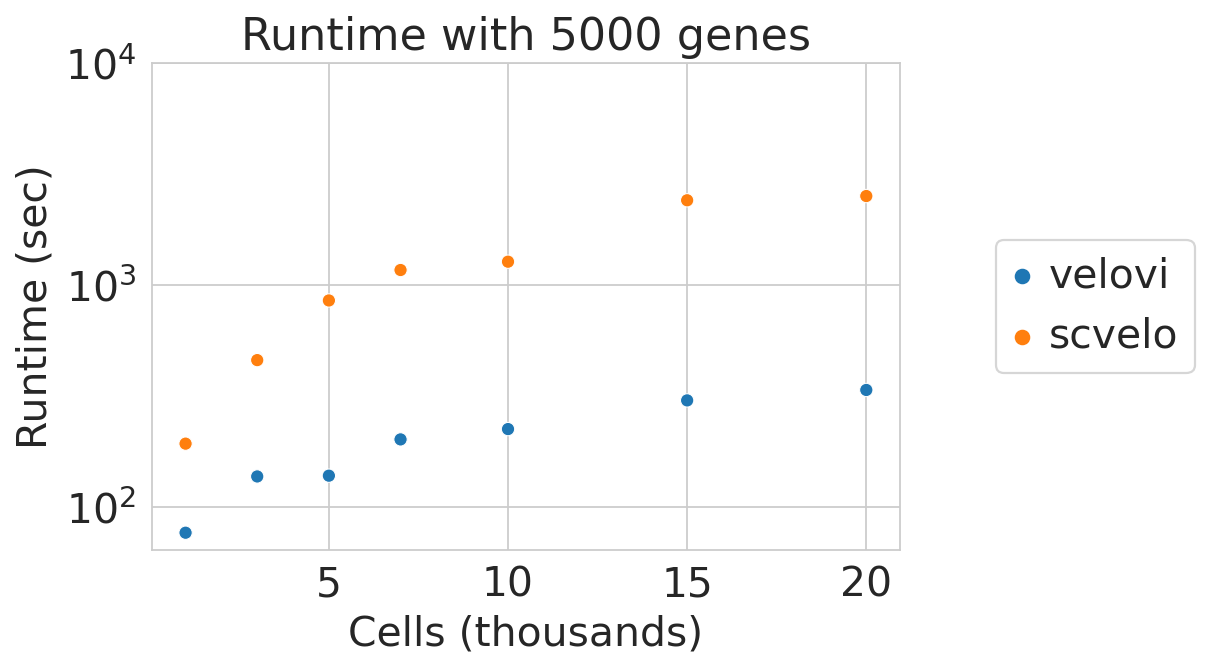

In [14]:
res_df['n_obs_thousand'] = res_df['n_obs'].astype(int) // 1e4
res_df['runtime'] = res_df['runtime'].astype(float)

sns.set_style(style="whitegrid")

fig, ax = plt.subplots(figsize=(6, 4))
with mplscience.style_context():
    sns.scatterplot(x='n_obs_thousand', y='runtime', hue='method', data=res_df, ax=ax)

ax.set_xlabel('Cells (thousands)')
ax.set_ylabel('Runtime (sec)')
ax.set_yscale('log')
ax.set_ylim((0, 1e4))
ax.set_title('Runtime with 5000 genes')
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'runtime.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight',
    )